In [25]:
import itertools

import utils
from PolishSystem.OperatorsBasedOnSimilarities.get_operators import get_operators_for_similarities
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities
from PolishSystem.GlobalPSPolishSearch import find_ps_in_polish_problem
from initial_testing.rearrange_linkage_table import clean_table
from PolishSystem.read_data import get_pRef_from_vectors, get_vectors_file_name, get_fitness_file_name
from Core.PS import PS, STAR
from SimplifiedSystem.ps_search_utils import get_metric_function
from Core.PSMetric.Simplicity import Simplicity
import numpy as np


# this section will generate the search objectives
size = 100
method = "qmc"
fitness_column_to_use = 2
data_folder = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"

pRef = get_pRef_from_vectors(get_vectors_file_name(data_folder, size, method), 
                                     get_fitness_file_name(data_folder, size, method), fitness_column_to_use)
best_solution = pRef.get_best_solution()

simplicity = get_metric_function("simplicity")
sample_size = get_metric_function("sample_count", pRef=pRef)
variance = get_metric_function("variance", pRef=pRef)
mean_fitness = get_metric_function("mean_fitness", pRef=pRef)
consistency = get_metric_function("consistency/greater", pRef=pRef)

cluster_info_file_name = os.path.join(data_folder, f"cluster_info_{size}_{method}.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

sampler, mutation, crossover= get_operators_for_similarities(similarities, pRef, wanted_average_quantity_of_ones=2)


def make_cached_metric(original_metric):
    cached_values = dict()
    
    def get_value(ps):
        if ps in cached_values:
            return cached_values[ps]
        else:
            value = original_metric(ps)
            cached_values[ps] = value
            return value
    return get_value


def atomicity_on_similarity(ps):
    if ps.fixed_count() < 2:
        return 1000
    else:
        valid_indices = [index for index, value in enumerate(ps.values) if value != STAR]
        linkages = [similarities[a, b] for a, b in itertools.combinations(valid_indices, r=2)]
        return -np.average(linkages)
    
    


pss = find_ps_in_polish_problem(original_problem_search_space=pRef.search_space,
                          objectives=[make_cached_metric(sample_size), make_cached_metric(consistency), make_cached_metric(atomicity_on_similarity)],
                          ps_budget=10000,
                          population_size=60,
                          sampling_operator=sampler,
                          mutation_operator=mutation,
                          crossover_operator=crossover,
                          culling_method=None,
                          verbose=True,
                          )



n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       41 |      7 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      101 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1873935661 |         nadir
     3 |      161 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0222316313 |             f
     4 |      221 |      7 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      281 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0503965265 |         nadir
     6 |      341 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |      400 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0027613935 |         nadir
     8 |      460 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0229651853 |         nadir
     9 |      519 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      579 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

The overall mean is 3.534054927435413
[22, 41] sample_quantity = 16827.0, p_value = 0.002, atomicity = 0.08
[13, 22] sample_quantity = 16423.0, p_value = 0.000, atomicity = 0.05
[2, 22] sample_quantity = 10366.0, p_value = 0.000, atomicity = 0.07


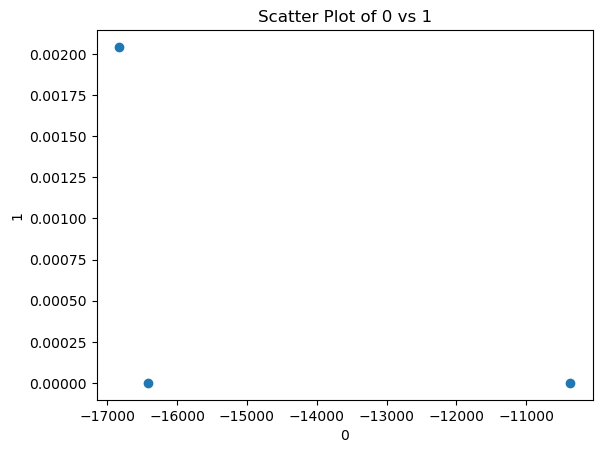

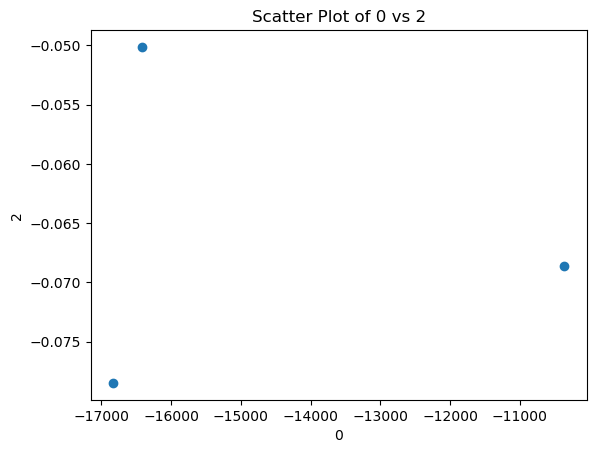

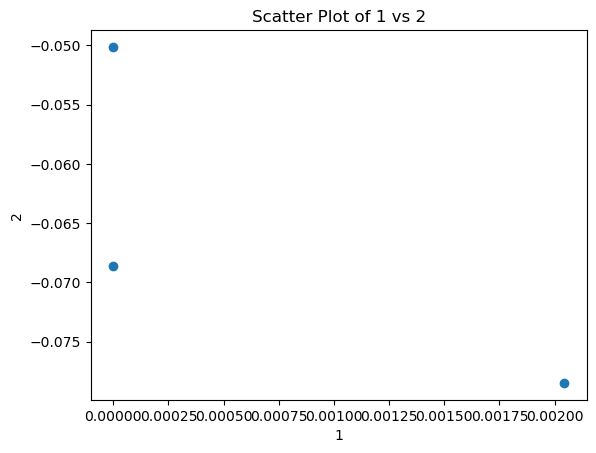

In [26]:
from Core.PSMetric.FitnessQuality.SignificantlyHighAverage import MannWhitneyU
from Core.EvaluatedPS import EvaluatedPS

universality_threshold = 1000

def is_good_ps(ps: EvaluatedPS, verbose=False) -> bool:
    non_trivial = ps.fixed_count() > 1
    enough_samples = (-sample_size(ps)) > universality_threshold
    provably_good = consistency(ps) < 0.05
    positive_atomicity = atomicity_on_similarity(ps) < 0  # since it's negated
    if verbose:
        if not non_trivial:
            print(f"The ps is nearly trivial, {ps.fixed_count() = }")
        if not enough_samples:
            print(f"The ps does not have enough samples, {-sample_size(ps) =}")
        if not provably_good:
            print(f"The ps is not provably good, consistency = {consistency(ps) = }")
        if not positive_atomicity:
            print(f"The ps does not have positive atomicity, {-atomicity_on_similarity(ps) = }")
    return non_trivial and enough_samples and provably_good and positive_atomicity

mean_overall = pRef.cached_mean
print(f"The overall mean is {mean_overall}")
pss_to_show = list(set(pss))
pss_to_show = [ps for ps in pss_to_show 
              if is_good_ps(ps)]

pss_to_show.sort(key=lambda x: x.metric_scores[0])

def get_indices(ps):
    return [index for index, value in enumerate(ps.values) if value != -1]

for ps in pss_to_show:
    sample_quantity = -ps.metric_scores[0]
    p_value = ps.metric_scores[1]
    atomicity = -ps.metric_scores[2]
    print(get_indices(ps), f"{sample_quantity = }, {p_value = :.3f}, {atomicity = :.2f}")


def plot_for_dims(x_dim, y_dim):
    utils.simple_scatterplot(x_label = f"{x_dim}",
                             y_label=f"{y_dim}",
                             xs = [ps.metric_scores[x_dim] for ps in pss_to_show],
                             ys = [ps.metric_scores[y_dim] for ps in pss_to_show],
                             )
    
for x_dim, y_dim in itertools.combinations(range(3), r=2):
    plot_for_dims(x_dim, y_dim)